# 10. 검정

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

from utils import set_pyplot_params
set_pyplot_params()

'**정보 이론, 추론, 알고리즘 학습**'에서 데이비드 맥케이는 다음의 문제를 제안

2002년 1월 4일 금요일, 가디언지에 다음과 같은 통계 기사가 게재

> 벨기에 1유로 동전을, 축을 중심으로 250번 회전을 시켰는데, 앞면이 140회, 뒷면은 110회가 나타남
> 런던 경제학교(LSE) 통계학 교수 배리 브라이트는 "매우 의심스럽다. 만약 동전이 한 쪽으로 기울어진 것이 아니라면, 결과가 이렇게 치우칠 확률은 7% 미만이다"

- 이 데이터가 동전이 한 쪽으로 기울었다는 것의 증거가 되는가?

<br>

**이 문제를 풀기 위한 모델의 전제조건**

- 어떤 동전이든 세워서 돌리면, 앞면을 보이며 넘어질 확률을 가진다.

    이 확률을 $x$라고 할때, $x$는 무게 분산 등 물리적 특성에 영향을 받는다고 판단할 수 있다.

- 만약 동전의 무게가 완벽한 균형을 이루고 있다면, $x$는 50%에 근접하다고 생각하겠지만, 동전의 무게가 어느 한쪽에 치우쳐 잇다면, $x$는 이에 따라 달라진다.

<br>

- **우선 $x$의 모든 값이 동일한 정도로 가능하다고 가정하는 균등분포를 사전분포로 두고 시작**
    
    (앞면을 보이며 넘어질 확률이 $x$일 확률 = 1 / 101)

<br>

## 10.01. 추정

In [2]:
import numpy as np
from empiricaldist import Pmf

In [3]:
xs = np.linspace(0, 1, 101)
uniform = Pmf(1, xs)

- 이항분포를 사용해서 $x$의 각 가능한 값에 대해 데이터의 확률을 계산

In [4]:
from scipy.stats import binom

In [5]:
k, n = 140, 250
likelihood = binom.pmf(k, n, xs)

In [6]:
posterior = uniform * likelihood
posterior.normalize()

0.3984063745019918

In [7]:
from utils import decorate

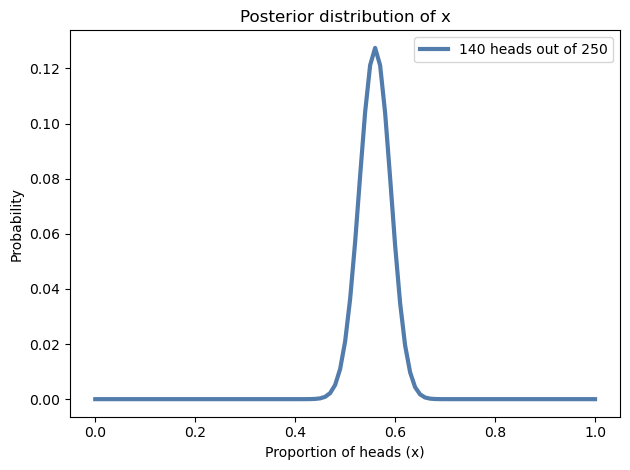

In [8]:
posterior.plot(label='140 heads out of 250')

decorate(xlabel='Proportion of heads (x)', ylabel='Probability', title='Posterior distribution of x')

- 사후평균은 0.56이며, 90% 신용구간은 0.51 ~ 0.61

In [9]:
print(posterior.mean(), posterior.credible_interval(0.9))

0.5595238095238094 [0.51 0.61]


#### 사전평균은 0.5, 사후평균은 0.56이므로, 이 데이터는 동전이 기울었다는 증거가 됨
#### 하지만 이 문제에 대한 이런 접근은 이렇게 단순하지 않음

<br>

## 10.02. 증거

**데이터가 가설 B에서 가설 A하에서 발생했을 가능성이 더 높을 때, 데이터는 가설 A에 부합하는 증거이며**

$$P(D|A) > P(D|B)$$

**더 나아가, 가능도의 비율을 구함으로써 증거의 강도를 정량화할 수 있음, 이를 베이즈 요인 (Bayes factor)라 하고 보통 $K$로 표현**

$$K = \frac{P(D|A)}{P(D|B)}$$

**따라서 동전 문제에서 `fair`와 `biased`라는 두 가지 가설을 고려하여, 각 가설 하의 데이터의 가능도를 계산**

**동전이 균일하면 앞면의 확률은 50%이고, 이항분포를 사용해서 데이터 (250회 중 140개개의 앞면)대로 나올 확률을 계산 가능**

<br>

- 동전이 균일하다는 가설 (p = 0.5)에서의 140개의 앞면이 나올 확률

In [10]:
k = 140
n = 250

like_fair = binom.pmf(k, n, p=0.5)
like_fair

0.008357181724918204

- 동전이 균일하지 않다는 가설 (p = 0.56)에서 140개의 앞면이 나올 확률

In [11]:
like_biased = binom.pmf(k, n, p=0.56)
like_biased

0.05077815959518339

<br>

**가능도비 $K=6.08$**

In [12]:
K = like_biased / like_fair
K

6.075990838368468

#### 동전이 균일한 것보다 한 쪽으로 치우쳤을 가능성이 6배 가량 높음

#### 하지만, 가설 정의를 위해서는 '동전이 균등하지 않다'는 가설에 대한 정의가 필요

<br>

## 10.03. 균등분포 형태의 치우침

**'동전이 균등하지 않다'를 $p$가 0.5가 아닌 것 이라고 정의할 시 $(p \neq 0.5)$**

**균등분포를 생성한 후, 50%영역을 삭제 ($f(y=0.5) = 0$)**

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

In [17]:
biased_uniform = uniform.copy()
biased_uniform[0.5] = 0
biased_uniform.normalize()

100

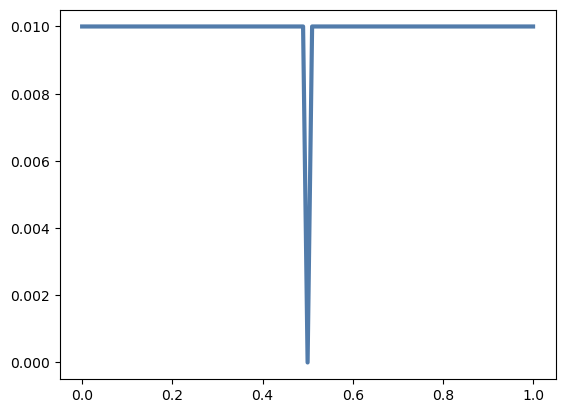

In [18]:
biased_uniform.plot()
plt.show()

**이 가설 하에서의 데이터의 전체확률을 구하기 위하여, $x$의 각 값에 대한 데이터의 조건부확률을 계산**

In [19]:
xs = biased_uniform.qs
likelihood = binom.pmf(k, n, xs)

**사전확률을 곱하고, 각 결괏값을 더함**

In [20]:
like_uniform = np.sum(biased_uniform * likelihood)
like_uniform

0.003900491927770735

#### 이 값은 '균등하게 치우친'가설 하에서의 데이터의 확률

<br>

`fair`과 `biased`에서의 균등 가설 하에서 데이터의 가능도 비율 $K$

In [21]:
K = like_fair / like_uniform
K

2.1425968518013625

**동전이 균일하다는 가설보다, 동전이 치우치다라는 가설에서 가능도가 2배가량 높음**

<br>

예를 들어, 동전이 치우쳤을 사전확률이 50% $\rightarrow$ 사전 공산이 1

사후 공산은 1에서 2.1이 될 것이고, 사후 확률은 약 68%가 됨

In [22]:
prior_odds = 1
posterior_odds = prior_odds * K
posterior_odds

2.1425968518013625

In [23]:
def prob(o):
    return o / (o+1)

In [24]:
posterior_probability = prob(posterior_odds)
posterior_probability

0.6817918278551092

<br>

#### '치우치다'가 $x$의 모든 값에 대해 동일한 가능성을 가지는 것을 의미하지는 않는다고 가정할 경우

**$\rightarrow$ 50%근처의 값이 더 가능성이 높고 극단적인 값의 가능성은 좀 더 낮을 수 있음**

**$\rightarrow$ 삼각사전분포 사용**

In [26]:
ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)
a = np.append(ramp_up, ramp_down)

triangle = Pmf(a, xs, name='triangle')
triangle.normalize()

2500

**삼각분포를 생성한 후, 50%영역을 삭제 ($f(y=0.5) = 0$)**

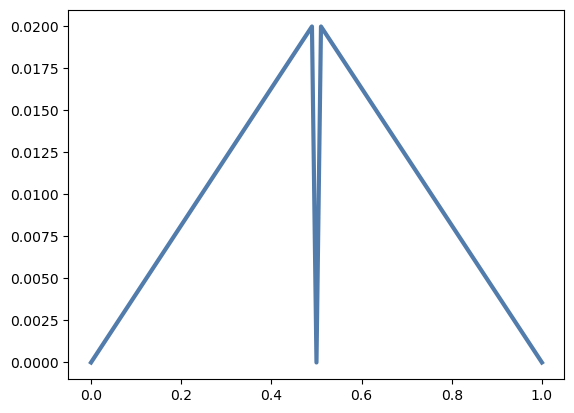

In [34]:
biased_triangle = triangle.copy()
biased_triangle[0.5] = 0
biased_triangle.normalize()

biased_triangle.plot()
plt.show()

<br>

#### 균등분포와 삼각분포의 비교

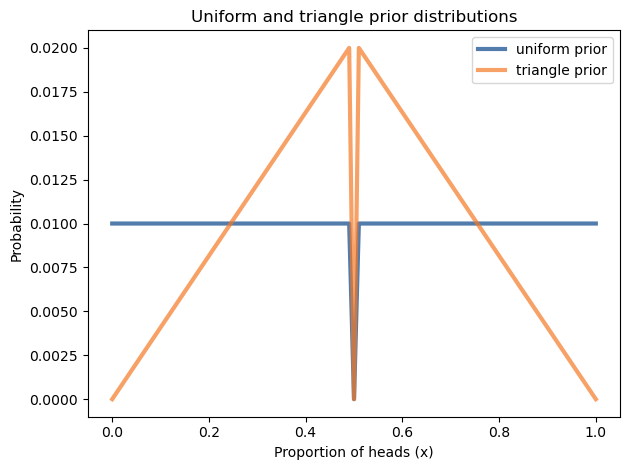

In [31]:
biased_uniform.plot(label='uniform prior')
biased_triangle.plot(label='triangle prior')

decorate(xlabel='Proportion of heads (x)', ylabel='Probability', title='Uniform and triangle prior distributions')

In [39]:
like_triangle = np.sum(biased_triangle * likelihood)
like_triangle

0.00698132546485788

In [38]:
K = like_fair / like_triangle
K

1.1970766535647157

<br>

## 10.04 베이지안 가설 검정

<br>

### 통계적 가설 검정
- 통계적 가설 검정에서는, 간단히 정의하기 어려운 p-값을 구해서, 통계적으로 유의성을 판단

<br>

### 베이지안 가설 검정
- 하나의 가설이나, 다른 가설에 대한 증거의 강도를 요약한 값인 베이즈 계수 $K$를 사용
    - $K$는 가설의 명확한 정의에 따라 달라질 수 있음
- **베이지안 가설 검정은 0과 1로 결정되는 것이 아닌, 연속 형태로 증거의 강도를 측정함**



<br>

## 10.05. 베이지안 밴딧

- 베이지안 가설 검정 예시 중 하나
- **슬롯 머신을 단순화한 형태를 기반으로 문제를 해결**

<br>

#### 슬롯 머신에서 이길 확률은 이미 정해져 있으며, 각각의 슬롯 머신마다 이길 확률이 다 다르지만 그 확률을 알 수 없음
- **처음 각 슬롯 머신 각각에 대한 사전 믿음은 동일하기 때문에, 특정 슬롯 머신을 선호할 이유가 없음**
    
    **하지만, 각 슬롯 머신에서 게임을 몇 번씩 해보면, 이 결과로 확률을 추정할 수 있으며**

    **추정한 확률을 기반으로 다음에는 어떤 슬롯 머신을 고를지 정할 수 있음**


<br>

## 10.06. 사전 믿음

**승률에 대해 아무것도 모르고 있을 때는, 균등분포로 시작**

In [40]:
xs = np.linspace(0, 1, 101)
prior = Pmf(1, xs)
prior.normalize()

101

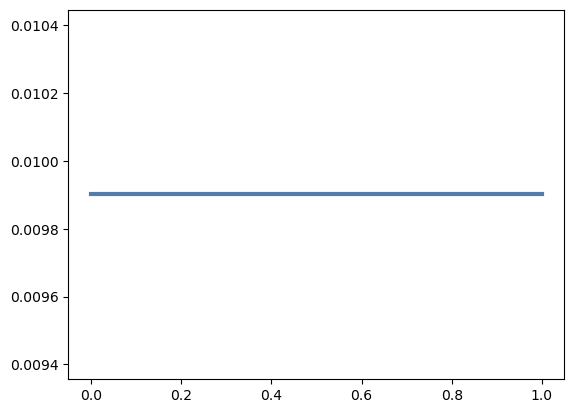

In [42]:
prior.plot()
plt.show()

<br>

#### 4개의 슬롯 머신중 하나를 고른다고 가정하면, 사전확률분포를 4개로 복사한 후, 각 슬롯 머신에 하나씩 할당

In [43]:
beliefs = [prior.copy() for i in range(4)]

In [44]:
options = dict(xticklabels='invisible', yticklabels='invisible')

def plot(beliefs, **options):
    for i, pmf in enumerate(beliefs):
        plt.subplot(2, 2, i+1)
        pmf.plot(label='Machine %s' % i)
        decorate(yticklabels=[])
        
        if i in [0, 2]:
            decorate(ylabel='PDF')
        
        if i in [2, 3]:
            decorate(xlabel='Probability of winning')
        
    plt.tight_layout()

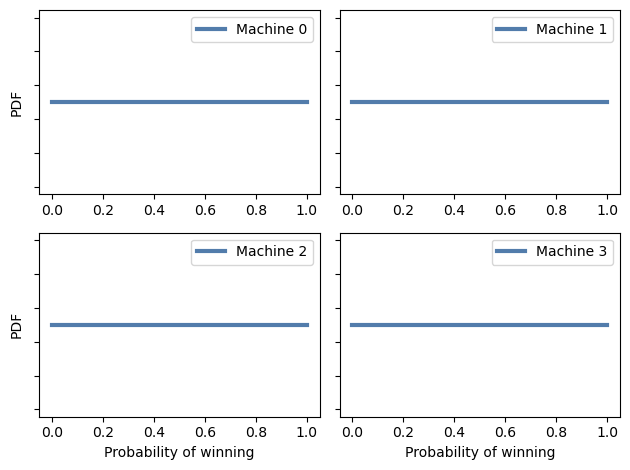

In [45]:
plot(beliefs)

<br>

## 갱신

#### 게임을 한 판씩 해가면서, 이 결과로 믿음을 갱신
- 갱신에는 다음 함수를 사용

In [46]:
likelihood = {
    'W': xs,
    'L': 1 - xs
}

In [47]:
def update(pmf, data):
    
    """승률을 갱신"""
    pmf *= likelihood[data]
    pmf.normalize()

<br>

#### 슬롯 머신 하나를 선택해서, 게임을 10회 하고, 한번 이겼을 때

In [49]:
np.random.seed(17)

In [50]:
bandit = prior.copy()

for outcome in 'WLLLLLLLLL':
    update(bandit, outcome)

- 사후분포

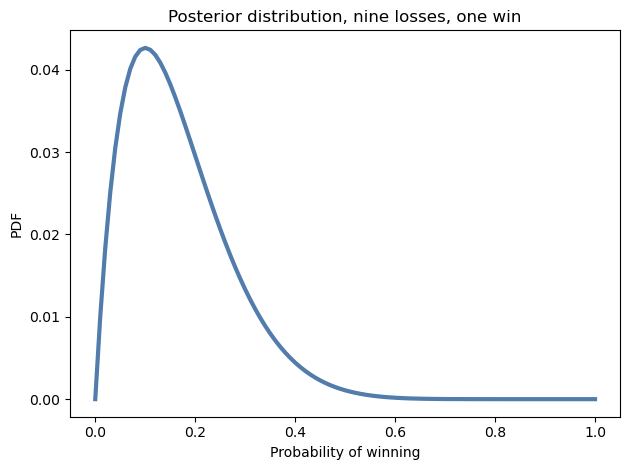

In [52]:
bandit.plot()
decorate(xlabel='Probability of winning', ylabel='PDF', title='Posterior distribution, nine losses, one win')

<br>

## 10.08. 여러 개의 밴딧

<br>

#### 다음 확률을 가지는 4개의 슬롯 머신

In [55]:
actual_probs = [0.10, 0.20, 0.30, 0.40]

<br>

- **슬롯 머신을 쓰는 사람은 이 확률을 알 수 없음**

In [56]:
from collections import Counter

In [58]:
# 각 슬롯 머신을 몇 회 실행했는지 기록
counter = Counter()

def play(i):
    """
    슬롯머신 i를 실행한다
    
    i : 실행할 슬롯 머신의 인덱스
    
    반환값 : 문자열 'W' 혹은 'L'
    """
    counter[i] += 1
    p = actual_probs[i]
    
    if np.random.random() < p:
        return 'W'
    else:
        return 'L'

<br>

#### 각 슬롯 머신을 10회 돌리는 경우를 테스트

In [59]:
for i in range(4):
    for _ in range(10):
        outcome = play(i)
        update(beliefs[i], outcome)

<br>

- 사후분포

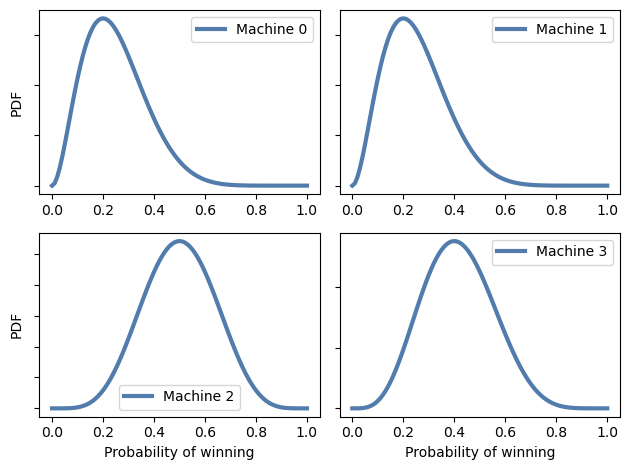

In [61]:
plot(beliefs)

<br>

#### 실제 확률과 사후평균, 95% 신용구간
- 신용구간에 대부분의 실제 확률이 포함되어 있을 것이라고 예상

In [65]:
import pandas as pd

In [70]:
def summarize_beliefs(beliefs):

    columns = ['실제 확률', '사후분포 평균', '95% 신용구간']
    
    df = pd.DataFrame(columns=columns)
    
    for i, b in enumerate(beliefs):
        
        mean = np.round(b.mean(), 3)
        ci = b.credible_interval(0.95)
        ci = np.round(ci, 3)
        
        df.loc[i] = actual_probs[i], mean, ci
        
    return df

In [71]:
summarize_beliefs(beliefs)

,실제 확률,사후분포 평균,95% 신용구간
0,0.1,0.250,"[0.06, 0.52]"
1,0.2,0.250,"[0.06, 0.52]"
2,0.3,0.500,"[0.23, 0.77]"
3,0.4,0.417,"[0.17, 0.69]"


<br>

## 10.09. 탐색과 활용

<br>

#### 위 사후분포를 근거로 했을 떄, 슬롯머신을 선택할 한 가지 선택지로는 가장 높은 사후평균을 가진 슬롯 머신을 선택
- **다만, 각 슬롯 머신에서 몇 번씩밖에 게임을 하지 않았기에, 사후분포는 넓고 겹치는 부분도 많음**

    **즉 어느 슬롯 머신이 가장 나은지 확실하지 않음**
    
    만약, 한 슬롯 머신에 너무 빨리 정착해 버린다면, 잘못 고른 슬롯 머신에서 더 많이 게임을 하게 될 수도 있음
    
<br>

#### 이런 문제를 피하기 위하여, 가장 확률이 좋은 슬롯 머신을 찾았다고 확신할 수 있을 때까지 모든 슬롯 머신에서 동일한 횟수로 게임
* **다만, 데이터를 모으는 동안에는 그 데이터를 제대로 활용할 수 없음**

    어떤 슬롯 머신이 가장 나은 지를 알 때까지, 안 좋은 슬롯 머신에서도 그 만큼 게임을 진행해야함
    
<br>

#### 베이지안 밴딧 전략은 데이터 수집과 활용을 도시에 함으로써, 양쪽의 단점을 모두 피함
- **탐색과 활용 사이에서 균형을 찾음**

<br>

### 톰슨 샘플링
- **슬롯 머신을 임의로 고를 때, 각 슬롯 머신을 고를 확률이 이 슬롯 머신이 가장 나을 확률에 비례하도록 함**

    $\rightarrow$ 주어진 사후분포에서, 각 슬롯 머신이 '가장 우수할 확률'을 구할 수 있음

<br>

#### 각 4개의 사후분포에서 1,000개의 값을 임의로 추출

In [134]:
samples = np.array([b.choice(1000) for b in beliefs])
samples.shape

(4, 1000)

In [135]:
samples

array([[0.07, 0.27, 0.16, ..., 0.36, 0.61, 0.07],
       [0.15, 0.21, 0.27, ..., 0.25, 0.1 , 0.07],
       [0.63, 0.56, 0.76, ..., 0.61, 0.53, 0.57],
       [0.32, 0.34, 0.37, ..., 0.42, 0.52, 0.71]])

#### 각 열에서 가장 큰 값의 위치 $\rightarrow$ 각 샘플에서 가장 높은 값이 나온 슬롯머신

In [136]:
indices = np.argmax(samples, axis=0)
indices.shape

(1000,)

- 1회 샘플에서는, 3번째 슬롯머신이 가장 높은 값이 나옴

In [137]:
indices[0]

2

<br>

#### 각 슬롯머신마다, 가장 높은 값이 나온 횟수의 비율

In [138]:
pd.DataFrame({'result':list(indices)}).\
    groupby('result').agg(freq = ('result', 'count')).reset_index(drop=True)

,freq
0,48
1,40
2,603
3,309


In [139]:
pmf = Pmf.from_seq(indices)
pmf

,probs
0,0.048
1,0.040
2,0.603
3,0.309


<br>

#### 이 비율은 각 슬롯 머신이 가장 우수할 확률을 대략적으로 보여줌
**이 `Pmf`로부터 값을 가져와서, 슬롯 머신을 선택**

In [150]:
pmf.choice()

3

<br>

#### 하지만 매번 단일 값을 선택하는 것은 번거롭기에
**각 사후분포에서 임의로 값을 하나씩 가져와서, 이 중 가장 높은 값을 갖는 슬롯머신을 고름**

In [152]:
def choose(beliefs):
    
    """톰슨 샘플링을 사용해서 슬롯 머신을 선택
    
    각 분포에서 값을 하나씩 가져옴
    
    반환값 : 가장 높은 값을 가진 슬롯 머신의 인덱스
    """
    ps = [b.choice() for b in beliefs]
    
    return np.argmax(ps)

In [160]:
print([b.choice() for b in beliefs])

print(np.argmax([b.choice() for b in beliefs]))

[0.12, 0.09, 0.64, 0.55]
2


In [161]:
choose(beliefs)

3

<br>

## 10.10. 전략

<br>

#### 위 과정들은 종합해서, 다음과 같이 슬롯 머신을 고르고 한 번 실행한 후, 믿음을 갱신하는 함수를 생성

In [162]:
def choose_play_update(beliefs):
    """슬롯 머신을 고르고, 실행한 후, 믿음을 갱신"""
    
    # 슬롯 머신을 선택
    machine = choose(beliefs)
    
    # 실행
    outcome = play(machine)
    
    # 믿음 갱신
    update(beliefs[machine], outcome)

In [169]:
beliefs = [prior.copy() for i in range(4)]
counter = Counter()

<br>

**밴딧 알고리즘을 100회 실행**

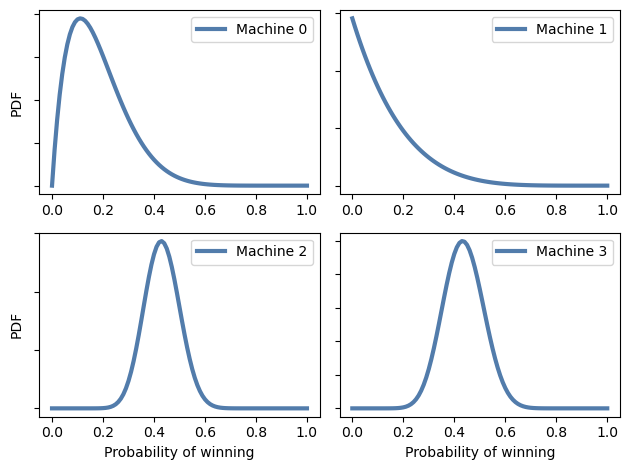

In [170]:
num_plays = 100

for i in range(num_plays):
    choose_play_update(beliefs)
    
plot(beliefs)

<br>

#### 신뢰구간에는 실제 승률이 포함
#### 추정치는 여전히 대략적이며, 특히 낮은 확률의 슬롯 머신에서는 이런 경향이 더 나타남

In [171]:
summarize_beliefs(beliefs)

,실제 확률,사후분포 평균,95% 신용구간
0,0.1,0.182,"[0.03, 0.45]"
1,0.2,0.139,"[0.0, 0.46]"
2,0.3,0.431,"[0.3, 0.57]"
3,0.4,0.436,"[0.29, 0.59]"


<br>

#### 슬롯 머신이 각각 몇 번이나 실행되었는 지 횟수
- 계획대로라면, 높은 확률을 가진 슬롯 머신을 보다 자주 실행

In [172]:
def summarize_counter(counter):
    index = range(4)
    columns = ['Actual P(win)', 'Times played']
    df = pd.DataFrame(index=index, columns=columns)
    
    for i, count in counter.items():
        df.loc[i] = actual_probs[i], count
        
    return df

In [173]:
summarize_counter(counter)

,Actual P(win),Times played
0,0.1,9
1,0.2,5
2,0.3,49
3,0.4,37


<br>


## 10.11 Summary

- 베이지안 밴딧 알고리즘은 탐색과 활용 간에 균형을 잡으면서, 보다 많은 정보를 수집하고 현재 보유하고 있는 정보를 최적으로 활용할 수 있도록 함

## 10.12 SAT 예시

SAT 시험의 목적은, 시험 대상자가 대학 과정을 이수할 준비가 되었는지를 측정하는 것

만약 이 시험이 정확하다면, 결과 점수는 시험 영역의 실제 능력을 반영할 것

<br>

한 학생이 처음 몇 문제를 맞췄다면, 더 어려운 문제를 제시하여 시험 난이도를 높일 수 있음

만약 계속 고전하고 있다면, 보다 쉬운 문제를 제시할 수 있음

<br>

따라서, 적응형 시험은 동일한 수의 문제를 가지고 시험을 보는 사람의 능력을 보다 정확하게 측정할 수 있으므로, 보다 '효율적'일 가능성이 존재

### 01. 모델링

- 사용할 모델은 각 질문의 난이도와 각 응시자의 능력을 정량화할 수 있다고 가정하는 [문항 응답 이론](https://en.wikipedia.org/wiki/Item_response_theory)을 기반으로 하며, 

    **올바른 응답의 확률은 난이도와 능력에 대한 함수**

- 특히, 일반적인 가정은 이 함수가 3개의 매개변수를 가진 로지스틱 함수

$$\mathrm{p} = c + \frac{1-c}{1 + e^{-{(\theta-b)}/{a}}}$$

- $\theta$는 응시자의 능력

- $b$는 문제의 난이도

- $c$는 능력이 가장 낮은 응시자가 가장 어려운 질문에 답하려고 한다고 가정할 때 문제를 맞힐 확률이 가장 낮음
        
    - 4개의 응답이 있는 객관식 테스트에서 $c$는 0.25가 될 수 있으며, 이는 무작위로 추측하여 정답을 얻을 확률

- $a$는 곡선의 모양을 제어

<br>

다음 함수는 '능력'과 '난이도'를 고려하여 정답 확률을 계산

In [260]:
def prob_correct(ability, difficulty):
    
    """정답을 고를 확률"""
    a = 100
    c = 0.25
    x = (ability - difficulty) / a
    p = c + (1-c) / (1 + np.exp(-x))
    
    return p

#### 난이도가 500일 대의 정답 확률

In [261]:
abilities = np.linspace(100, 900)
diff = 500
ps = prob_correct(abilities, diff)

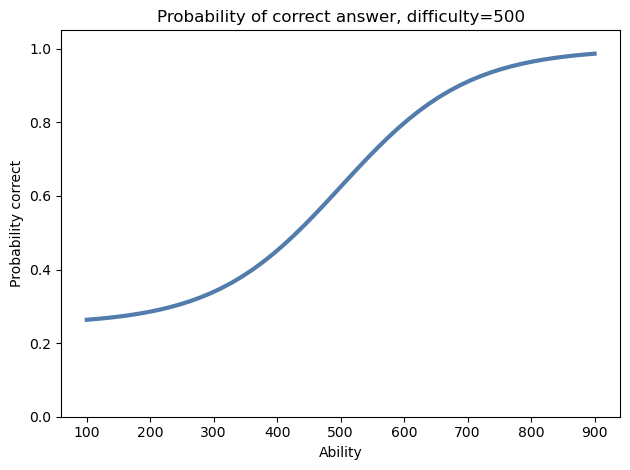

In [262]:
plt.plot(abilities, ps)
decorate(xlabel='Ability', ylabel='Probability correct', title='Probability of correct answer, difficulty=500', ylim=[0, 1.05])

#### `능력=900`을 가진 사람은 정답을 맞출 확률이 1에 수렴
#### `능력=100`인 사람은 추측을 통해 정답을 얻는 데 약 25%의 확률이 존재


<br>

### 02. 시뮬레이션

#### 시뮬레이션하기 위해 밴딧 전략에 사용한 것과 동일한 구조를 사용

* 응시자가 하나의 질문에 답하는 모습을 시뮬레이션하는 `play`

* 제기할 다음 질문을 선택하는 `choose

* 결과(정답 여부)를 사용하여 응시자의 능력 추정치를 업데이트하는 `update`

In [263]:
def play(ability, difficulty):
    """질문에 답하는 응시자를 시뮬레이션"""
    p = prob_correct(ability, difficulty)
    
    return np.random.random() < p

`play`는 `prob_corlect`를 사용하여 정답 확률을 계산하고 `np.random.random`을 사용하여 0과 1 사이의 무작위 값을 생성 

$\rightarrow$ 난수가 정답확률 보다 낮다면 `True`, 그렇지 않은 경우 `False` 반환

<br>

- `difficulty=500` 질문에 `ability=600`으로 답하는 응시자를 시뮬레이션 $\rightarrow$ 정답을 맞힐 확률은 약 80%

In [264]:
prob_correct(600, 500)

0.7982939339725037

<br>

#### 모두 같은 난이도 '500'의 51개 문항으로 시험을 본다고 가정 $\rightarrow$ 문제의 약 80%를 맞힐 것으로 기대

In [265]:
np.random.seed(18)

In [266]:
num_questions = 51
outcomes = [play(600, 500) for _ in range(num_questions)]
np.mean(outcomes)

0.803921568627451

<br>

#### 응시자의 능력을 모른다고 가정 $\rightarrow$ 방금 생성한 데이터를 사용하여 이를 추정

<br>


### 03. 사전

- SAT는 점수 분포가 평균 500, 표준편차 100인 정규 분포를 따르도록 설계

    따라서 가장 낮은 점수인 200은 평균보다 3표준편차 낮으며, 가장 높은 점수인 800은 평균보다 3표준편차 높음

- **해당 분포를 사전 분포로 사용할 수 있지만, 최저점과 최고점이 나올 확률을 낮추는 경향이 존재**

    **$\rightarrow$ 표준편차를 300으로 부풀려 '능력'이 200보다 작거나 800보다 클 수 있는 가능성을 증가시킴**


<br>

#### 응시자 능력에 대한 분포

In [267]:
from scipy.stats import norm

In [268]:
mean = 500
std = 300

qs = np.linspace(0, 1000)
ps = norm(mean, std).pdf(qs)

prior = Pmf(ps, qs)
prior.normalize()

0.04464186995102338

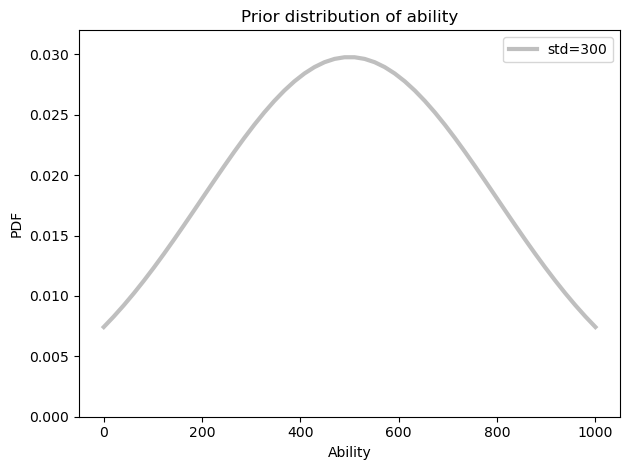

In [269]:
prior.plot(label='std=300', color='C5')

decorate(xlabel='Ability', ylabel='PDF', title='Prior distribution of ability', ylim=[0, 0.032])

<br>

### 04. 갱신


In [270]:
def update_ability(pmf, data):
    
    """응시자의 능력에 대한 분포를 갱신"""
    difficulty, outcome = data
    
    abilities = pmf.qs
    ps = prob_correct(abilities, difficulty)
    
    if outcome:
        pmf *= ps
    else:
        pmf *= 1 - ps
        
    pmf.normalize()

<br>

#### `난이도=500`으로 51개의 질문에 답한 `능력=600`인 사람을 기반으로 이전에 시뮬레이션한 결과를 기반으로 갱신

In [271]:
actual_600 = prior.copy()

for outcome in outcomes:
    data = (500, outcome)
    update_ability(actual_600, data)

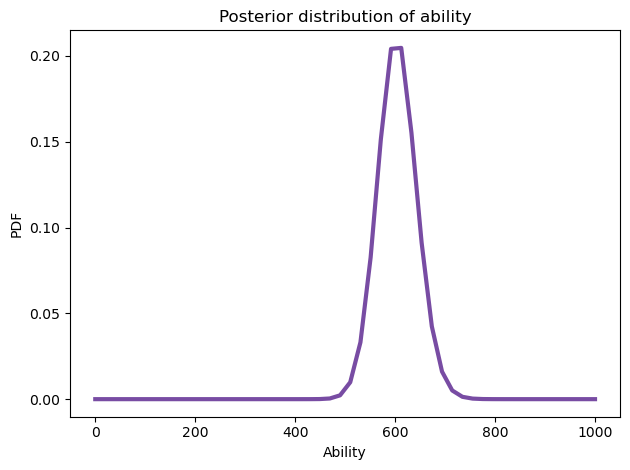

In [272]:
actual_600.plot(color='C4')

decorate(xlabel='Ability', ylabel='PDF', title='Posterior distribution of ability')

#### 사후 평균은 응시자의 실제 능력인 600에 매우 가까움

In [273]:
actual_600.mean()

604.3325737356816

<br>

### 05. 적용


In [274]:
def choose(i, belief):
    """다음 문제의 난이도를 선택"""
    return 500

#### 다음 함수는 응시자의 실제 능력을 알고 있는 경우를 시뮬레이션

In [275]:
def simulate_test(actual_ability):
    
    """응시자에 대한 시뮬레이션"""
    belief = prior.copy()
    trace = pd.DataFrame(columns=['difficulty', 'outcome'])

    for i in range(num_questions):
        difficulty = choose(i, belief)
        outcome = play(actual_ability, difficulty)
        data = (difficulty, outcome)
        update_ability(belief, data)
        trace.loc[i] = difficulty, outcome
        
    return belief, trace

#### 다음은 `능력=600`인 응시자의 예

In [276]:
belief, trace = simulate_test(600)

In [277]:
trace.head()

,difficulty,outcome
0,500,False
1,500,True
2,500,False
3,500,False
4,500,True


In [278]:
belief.head()

,probs
0.000000,9.779305e-18
20.408163,1.297373e-17
40.816327,1.777809e-17


In [279]:
trace['outcome'].sum()

42

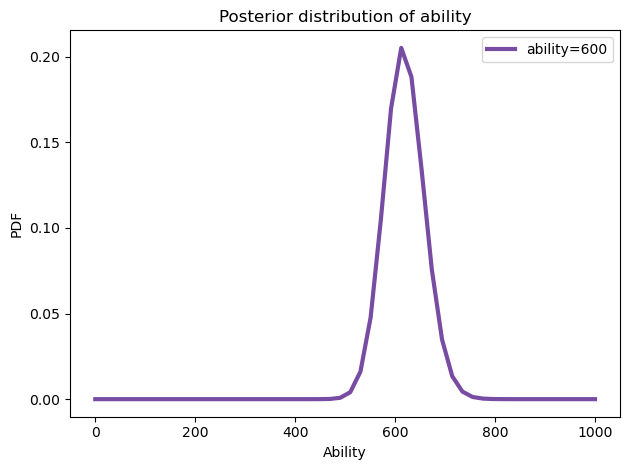

In [280]:
belief.plot(color='C4', label='ability=600')

decorate(xlabel='Ability', ylabel='PDF', title='Posterior distribution of ability')

#### 사후 분포는 응시자의 실제 능력에 대한 꽤 좋은 추정치를 나타냄

<br>

### 06. 정밀도 정량화

**추정치의 정확성을 정량화하기 위해 사후 분포의 표준 편차를 사용**

- **표준편차는 분포의 산포를 측정하므로, 표준편차가 높을수록 불확실성이 더 크다는 것을 나타냄**

<br>

**이전 예에서 사후 분포의 표준 편차는 약 40**

In [281]:
belief.mean(), belief.std()

(618.6942050450824, 40.08554296596485)

#### 모든 문제의 난이도가 동일한 시험의 경우, 추정의 정확성은 응시자의 능력에 따라 크게 달라짐. 

In [220]:
actual_abilities = np.linspace(200, 800)
results = pd.DataFrame(columns=['ability', 'posterior_std'])
series = pd.Series(index=actual_abilities, dtype=float, name='std')

for actual_ability in actual_abilities:
    belief, trace = simulate_test(actual_ability)
    series[actual_ability] = belief.std()

#### 각 능력 수준에서 한 시뮬레이션에 대한 사후 분포의 표준 편차

In [284]:
from utils import plot_series_lowess

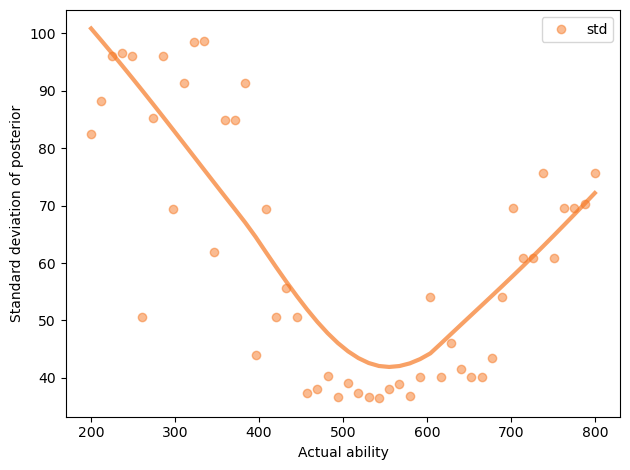

In [285]:
plot_series_lowess(series, 'C1')
decorate(xlabel='Actual ability',ylabel='Standard deviation of posterior')

- **이 테스트는 '500'에서 '600' 사이의 능력을 가진 사람들에게 가장 정확하고 (= 가장 낮은 표준편차)**

    **높은 범위에 있는 사람들에게는 덜 정확, 낮은 범위에 있는 사람들에게는 더욱 더 나쁨**

<br>

#### 테스트에 다양한 난이도의 질문이 포함된 경우 해당 범위의 최고 및 최저 수준에 있는 사람들에 대한 더 많은 정보를 확인할 수 있음

### 07. 검정력

- **테스트 성능을 설명하는 또 다른 방법(응시자의 성능과 반대)은 "검정력"을 측정하는 것**

    - 서로 다른 능력을 가진 응시자를 올바르게 구별하는 테스트

<br>

#### 검정력을 측정하기 위해 응시자에 대해 100번 시뮬레이션
- 각 시뮬레이션 후에는 사후 분포의 평균을 "점수"로 사용

In [227]:
def sample_posterior(actual_ability, iters):
    """여러 테스트를 시뮬레이션하고 사후 평균을 계산"""
    scores = []

    for i in range(iters):
        belief, trace = simulate_test(actual_ability)
        score = belief.mean()
        scores.append(score)
        
    return np.array(scores)

In [228]:
sample_500 = sample_posterior(500, iters=100)

In [229]:
sample_600 = sample_posterior(600, iters=100)

In [230]:
sample_700 = sample_posterior(700, iters=100)

In [231]:
sample_800 = sample_posterior(800, iters=100)

In [232]:
from empiricaldist import Cdf

In [233]:
cdf_500 = Cdf.from_seq(sample_500)
cdf_600 = Cdf.from_seq(sample_600)
cdf_700 = Cdf.from_seq(sample_700)
cdf_800 = Cdf.from_seq(sample_800)

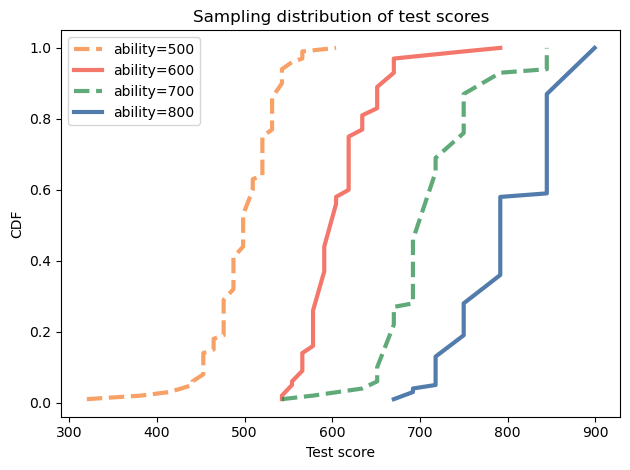

In [235]:
cdf_500.plot(label='ability=500', color='C1',linestyle='dashed')
cdf_600.plot(label='ability=600', color='C3')
cdf_700.plot(label='ability=700', color='C2', linestyle='dashed')
cdf_800.plot(label='ability=800', color='C0')

decorate(xlabel='Test score', ylabel='CDF',title='Sampling distribution of test scores')

#### 평균적으로 능력이 높은 사람이 더 높은 점수를 받지만, 분포 간에는 어느 정도 겹치는 부분이 존재

<br>

#### 능력이 높은 응시자가, 낮은 응시자보다 시험을 잘 볼 확률이 높음

In [236]:
np.mean(sample_600 > sample_500)

1.0

In [237]:
np.mean(sample_700 > sample_600)

0.93

In [238]:
np.mean(sample_800 > sample_700)

0.82